## Load clean data

In [1]:
import pandas as pd

import os

path = './data/clean/'
dataframes = {name.split('.')[0]: pd.read_csv(path + name) for name in os.listdir(path) if name != 'holidays.csv'}


### Join data

In [2]:
dataset_names = list(dataframes.keys())

df = dataframes[dataset_names[0]]

for name in dataset_names[1:]:
    df = df.merge(dataframes[name], on=['year', 'month', 'day', 'hour', 'daypart', 'is_holiday', 'common_id'])

df

,year,month,day,hour,daypart,is_holiday,common_id,intensity,occupation,congestion,...,nitrogen_dioxide,nitrogen_monoxide,nitrogen_oxides,non_methane_hydrocarbons,ozone,particles_lt_10,particles_lt_2_5,sulphur_dioxide,toluene,total_hydrocarbons
0,2019,1,1,0,1,1,10,137.536232,2.956522,8.777778,...,73.0,81.0,196.0,NaN,3.08,NaN,NaN,NaN,NaN,NaN
1,2019,1,1,0,1,1,9,53.420000,2.720000,6.820000,...,75.0,60.0,167.0,NaN,1.63,NaN,NaN,NaN,NaN,NaN
2,2019,1,1,0,1,1,8,110.805687,2.924171,6.890995,...,84.0,113.0,257.0,NaN,2.46,NaN,NaN,NaN,NaN,NaN
3,2019,1,1,0,1,1,7,159.027473,0.997253,5.497253,...,104.0,151.0,335.0,NaN,NaN,45.0,31.0,19.0,9.1,NaN
4,2019,1,1,0,1,1,6,99.345133,5.725664,8.876106,...,64.0,28.0,108.0,NaN,NaN,32.0,NaN,16.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322401,2022,9,30,23,1,0,8,170.388186,3.388186,9.341772,...,60.0,4.0,66.0,NaN,18.32,NaN,NaN,NaN,NaN,NaN
322402,2022,9,30,23,1,0,9,103.602410,2.602410,12.277108,...,54.0,5.0,61.0,NaN,23.20,NaN,NaN,NaN,NaN,NaN
322403,2022,9,30,23,1,0,10,167.664634,4.317073,12.490854,...,73.0,36.0,128.0,NaN,NaN,23.0,11.0,NaN,NaN,NaN
322404,2022,9,30,23,1,0,12,185.515152,4.946970,12.287879,...,54.0,2.0,58.0,NaN,17.80,NaN,NaN,NaN,NaN,NaN


### See variables distributions

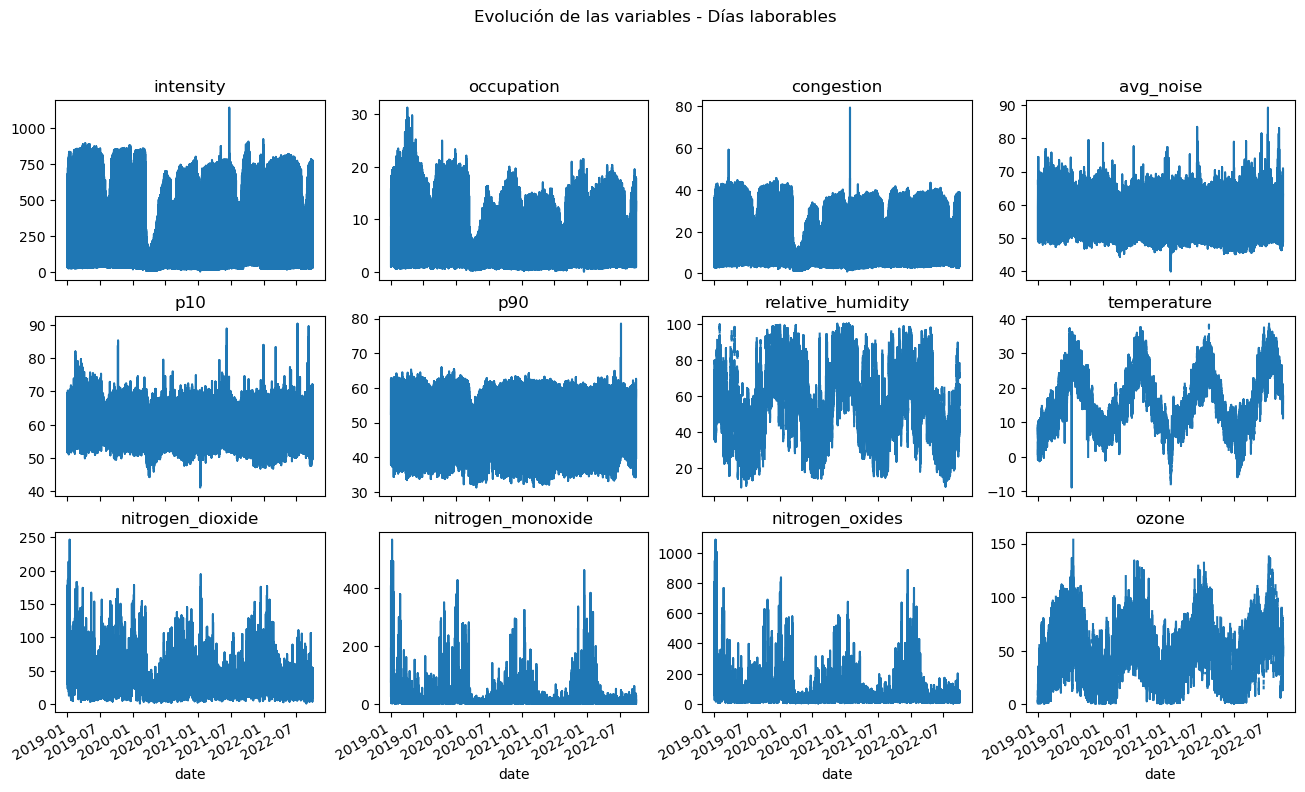

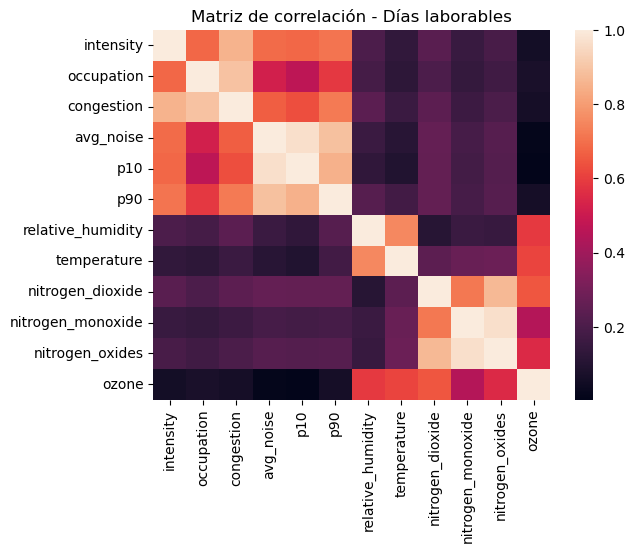

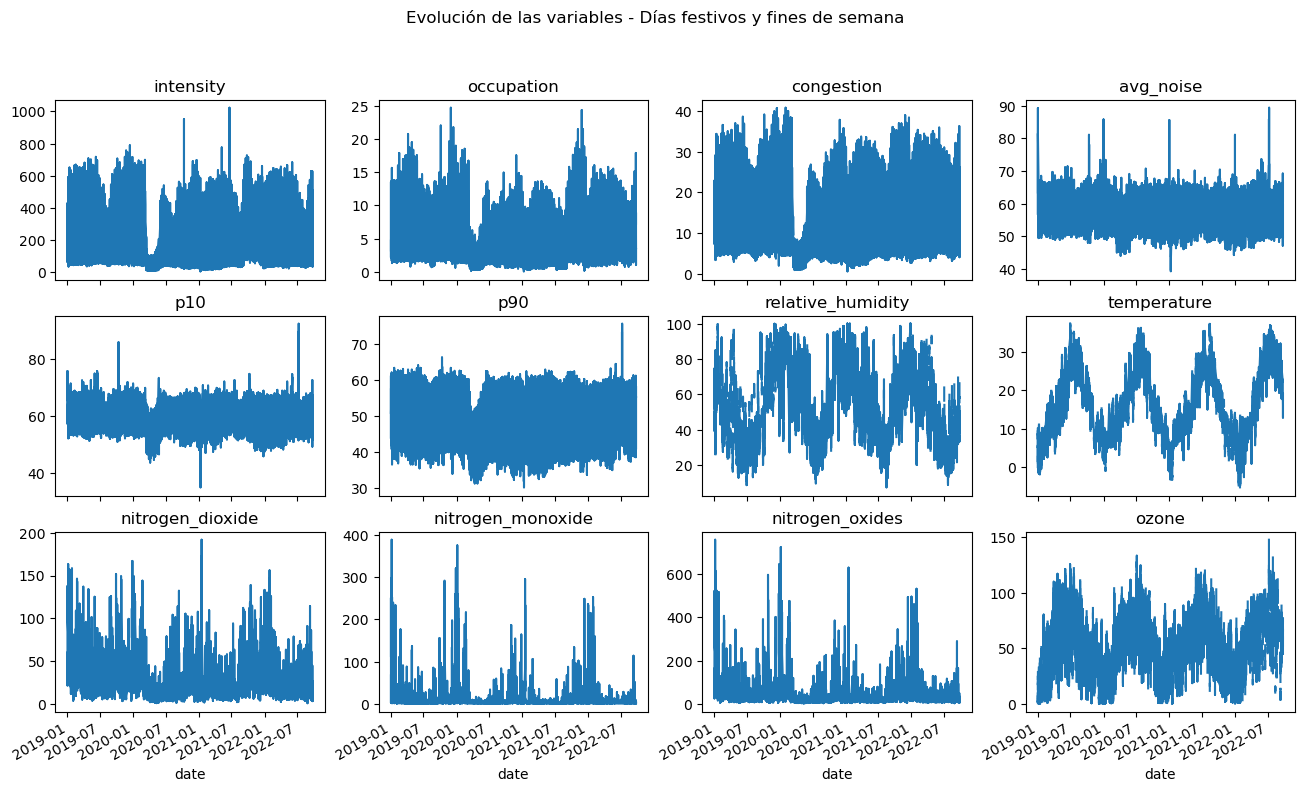

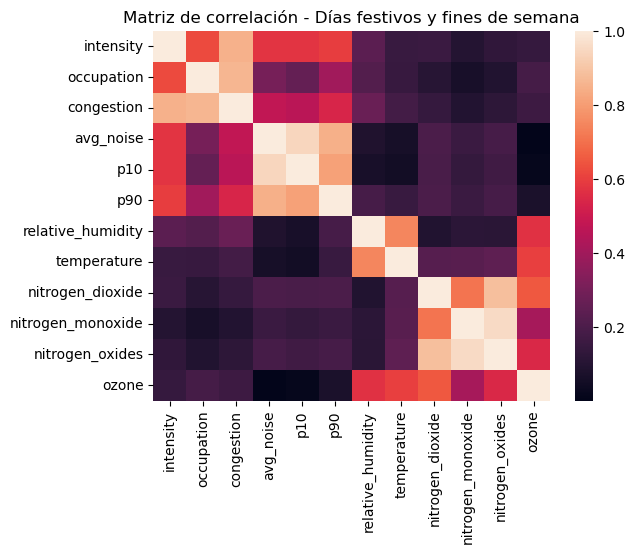

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# group data by (year, month, day, daypart and measure station)
df_grouped = df.groupby(['year', 'month', 'day', 'daypart', 'common_id']).mean().reset_index()

df_grouped['date'] = pd.to_datetime(df_grouped['year'].astype(str) + '/' + 
                                        df_grouped['month'].astype(str) + '/' + 
                                            df_grouped['day'].astype(str), 
                                    format='%Y/%m/%d')

# avoid using these columns for correlation matrix
discard = ['year', 'month', 'day', 'daypart', 'common_id', 'hour', 'is_holiday', 'date']

cols = [c for c in df_grouped.columns if c not in discard]

# discard columns that have >30% of theirs rows with NaN
df_grouped_nan = df_grouped.isna()
for c in cols:
    if df_grouped_nan[c].sum() > 0.3 * df_grouped_nan.shape[0]:
        discard.append(c)

cols = [c for c in df_grouped.columns if c not in discard and c not in ['p01', 'p50', 'p99']]

plt.subplots(3,4,figsize=(16,9))
plt.suptitle('Evolución de las variables - Días laborables')
for i, c in enumerate(cols):
    plt.subplot(3,4,i+1)

    df_grouped[df_grouped['is_holiday'] == 0].set_index('date')[c].plot()
    plt.gcf().autofmt_xdate()

    plt.title(c)
plt.show()

sns.heatmap(df[df['is_holiday'] == 0][cols].corr().abs())
plt.title('Matriz de correlación - Días laborables')
plt.show()

plt.subplots(3,4,figsize=(16,9))
plt.suptitle('Evolución de las variables - Días festivos y fines de semana')
for i, c in enumerate(cols):
    plt.subplot(3,4,i+1)

    df_grouped[df_grouped['is_holiday'] == 1].set_index('date')[c].plot()
    plt.gcf().autofmt_xdate()

    plt.title(c)
plt.show()

sns.heatmap(df[df['is_holiday'] == 1][cols].corr().abs())
plt.title('Matriz de correlación - Días festivos y fines de semana')
plt.show()

There is almost no correlation between traffic data and air quality data. 

There is an apparent correlation between traffic data and noise measurements.

### Group data in weeks and dayparts

In [4]:
df_simp = df.copy(deep=True)

df_simp['date'] = pd.to_datetime(df_simp['year'].astype(str) + '/' + df_simp['month'].astype(str) + '/' + df_simp['day'].astype(str), format='%Y/%m/%d')
df_simp['week'] = df_simp['date'].dt.isocalendar().week

df_simp

,year,month,day,hour,daypart,is_holiday,common_id,intensity,occupation,congestion,...,nitrogen_oxides,non_methane_hydrocarbons,ozone,particles_lt_10,particles_lt_2_5,sulphur_dioxide,toluene,total_hydrocarbons,date,week
0,2019,1,1,0,1,1,10,137.536232,2.956522,8.777778,...,196.0,NaN,3.08,NaN,NaN,NaN,NaN,NaN,2019-01-01,1
1,2019,1,1,0,1,1,9,53.420000,2.720000,6.820000,...,167.0,NaN,1.63,NaN,NaN,NaN,NaN,NaN,2019-01-01,1
2,2019,1,1,0,1,1,8,110.805687,2.924171,6.890995,...,257.0,NaN,2.46,NaN,NaN,NaN,NaN,NaN,2019-01-01,1
3,2019,1,1,0,1,1,7,159.027473,0.997253,5.497253,...,335.0,NaN,NaN,45.0,31.0,19.0,9.1,NaN,2019-01-01,1
4,2019,1,1,0,1,1,6,99.345133,5.725664,8.876106,...,108.0,NaN,NaN,32.0,NaN,16.0,NaN,NaN,2019-01-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322401,2022,9,30,23,1,0,8,170.388186,3.388186,9.341772,...,66.0,NaN,18.32,NaN,NaN,NaN,NaN,NaN,2022-09-30,39
322402,2022,9,30,23,1,0,9,103.602410,2.602410,12.277108,...,61.0,NaN,23.20,NaN,NaN,NaN,NaN,NaN,2022-09-30,39
322403,2022,9,30,23,1,0,10,167.664634,4.317073,12.490854,...,128.0,NaN,NaN,23.0,11.0,NaN,NaN,NaN,2022-09-30,39
322404,2022,9,30,23,1,0,12,185.515152,4.946970,12.287879,...,58.0,NaN,17.80,NaN,NaN,NaN,NaN,NaN,2022-09-30,39


In [16]:
group_cols = ['year', 'week', 'daypart', 'is_holiday']

df_simp_new = df_simp.drop(columns=['month', 'day', 'hour', 'common_id', 'date']).groupby(group_cols).mean().reset_index()

df_keep_order = df_simp[['year', 'week', 'daypart', 'is_holiday', 'month']].groupby(group_cols).min().reset_index()

df_simp_new = df_simp_new.merge(df_keep_order, on=group_cols)

# keep correct order
df_simp_new = df_simp_new.sort_values(by=['year', 'month', 'week', 'daypart']).reset_index()

df_simp_new

,index,year,week,daypart,is_holiday,intensity,occupation,congestion,avg_noise,p01,...,nitrogen_monoxide,nitrogen_oxides,non_methane_hydrocarbons,ozone,particles_lt_10,particles_lt_2_5,sulphur_dioxide,toluene,total_hydrocarbons,month
0,0,2019,1,0,0,424.856886,10.316239,28.221975,63.228165,70.412500,...,90.363782,214.014423,0.157288,11.727219,33.182171,20.944444,15.890578,4.326966,1.871525,1
1,1,2019,1,0,1,262.102601,6.155199,17.260389,61.036364,68.445455,...,64.292929,167.136364,0.163056,15.771701,29.470149,22.611111,16.782407,3.011111,1.966111,1
2,2,2019,1,1,0,101.227587,2.131450,6.472509,56.407547,65.881132,...,53.063679,135.033019,0.134750,8.224875,23.491124,17.822917,11.696429,3.380000,1.831000,1
3,3,2019,1,1,1,173.433326,3.641584,10.959477,61.612121,70.757576,...,85.329545,200.219697,0.247917,5.116250,43.033708,28.270833,14.534722,5.116667,2.153750,1
4,4,2019,1,2,0,398.945644,10.403826,27.419844,63.131754,70.219431,...,208.421801,438.753555,0.250500,2.801195,52.852273,28.375000,18.928571,8.943333,2.122500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1165,2022,38,2,0,401.214269,8.923716,26.582928,61.784000,69.582000,...,6.145000,50.465000,NaN,66.513571,18.462500,9.866667,3.333333,1.310000,NaN,9
1169,1166,2022,38,2,1,346.297839,7.558720,22.727948,61.795000,69.465000,...,2.012500,17.875000,NaN,67.550179,9.968750,4.625000,2.916667,0.375000,NaN,9
1170,1167,2022,39,0,0,457.311546,10.815237,30.034645,62.489138,70.800172,...,13.545927,46.164645,NaN,55.370418,15.376147,5.899408,3.769697,1.585714,NaN,9
1171,1168,2022,39,1,0,100.135416,2.004786,6.522355,55.054000,64.710000,...,3.700000,27.720000,NaN,47.964179,9.787500,4.666667,3.150000,0.874167,NaN,9


/home/miguel/miniconda3/envs/TF24/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/miniconda3/envs/TF24/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/miniconda3/envs/TF24/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/miniconda3/envs/TF24/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/home/miguel/miniconda3/envs/TF24/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter 

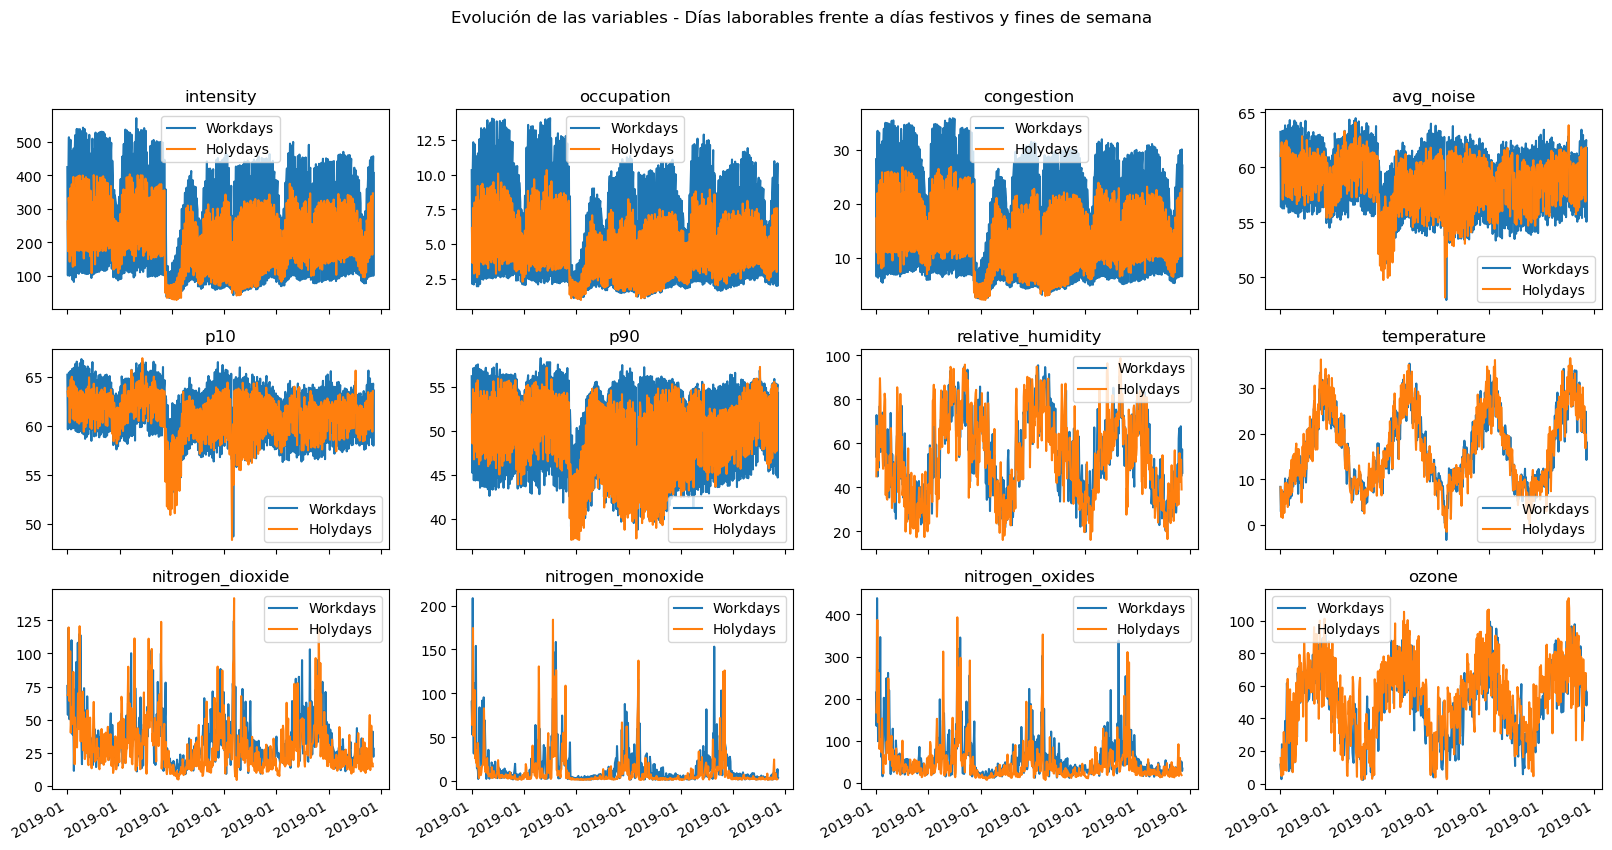

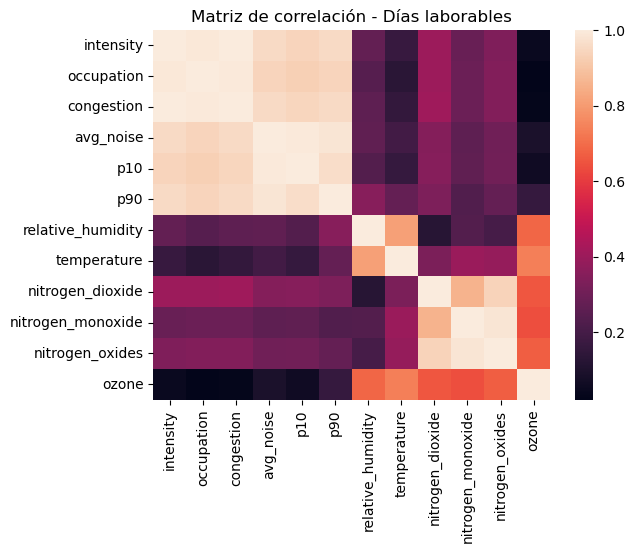

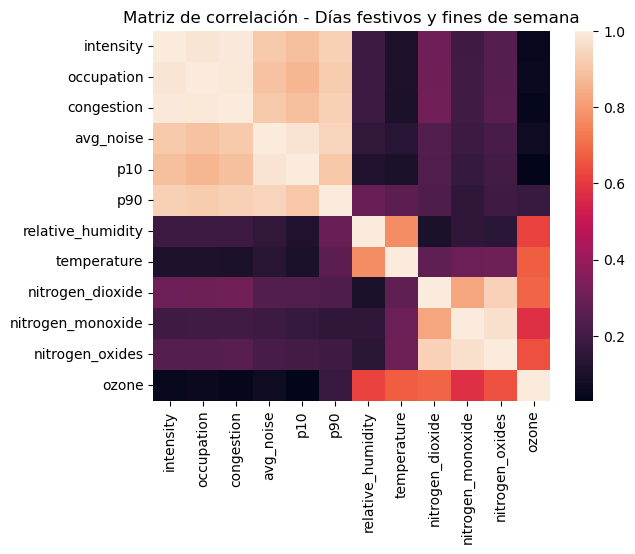

In [48]:
df_simp_new['year_month'] = df_simp_new['year'].astype(str) + '-' + df_simp_new['month'].astype(str).str.zfill(2)

_, axs = plt.subplots(3,4,figsize=(20,10))
plt.suptitle('Evolución de las variables - Días laborables frente a días festivos y fines de semana')
for i, c in enumerate(cols):
    plt.subplot(3,4,i+1)

    ax = df_simp_new[df_simp_new['is_holiday'] == 0][c].plot(label='Workdays')
    ax = df_simp_new[df_simp_new['is_holiday'] == 1][c].plot(label='Holydays', ax=ax)

    ax.set_xticklabels(df_simp_new['year_month'])

    plt.gcf().autofmt_xdate()

    plt.legend(loc='best')
    plt.title(c)
plt.show()

sns.heatmap(df_simp_new[df_simp_new['is_holiday'] == 0][cols].corr().abs())
plt.title('Matriz de correlación - Días laborables')
plt.show()

sns.heatmap(df_simp_new[df_simp_new['is_holiday'] == 1][cols].corr().abs())
plt.title('Matriz de correlación - Días festivos y fines de semana')
plt.show()

A high correlation between traffic and noise measurements can be observed when the data is grouped by weeks and parts of the day.

Considering this relationship, the model to be proposed will try to predict the noise measurements from the traffic data.

Periodicity is also apparent in the data for meteorological and air quality measurements. This could be useful for future work in predicting climate and air pollution using time series. 